In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Prepare Dataset

In [2]:
dataset_path = './Text_PreprocessingV2_Merged_Dataset.csv'

In [3]:
df = pd.read_csv(dataset_path, sep=',', header=None, skiprows=1)

# test_df.columns = ['text', 'label']
df.columns = ["label", "tweet_tokens_stemmed"]

In [4]:
df.head(10)

,label,tweet_tokens_stemmed
0,2,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,0,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba..."
4,1,"['duh', 'mahasiswa', 'sombong', 'kasih', 'kart..."
5,2,"['makan', 'agam', 'harga', 'makan', 'food', 's..."
6,1,"['pakai', 'kartu', 'kredit', 'baca', 'untung',..."
7,2,"['unik', 'bagus', 'foto', 'makan', 'enak', 'pe..."
8,2,"['keluarga', 'nikmat', 'alam', 'kuliner', 'sen..."
9,2,['syukur']


In [5]:
jumlah_positives = (df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 7151
Jumlah review negatif: 3830


## Preprocessing

In [6]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
df["tweet_join"] = df["tweet_tokens_stemmed"].apply(join_text_list)

df["tweet_join"].head()

0    warung milik usaha pabrik puluh kenal putih ba...
1    mohon ulama lurus mmbri hujjah partai diwlh su...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia unboxing paket barang bagus tet...
4    duh mahasiswa sombong kasih kartu kuning ajar ...
Name: tweet_join, dtype: object

In [7]:
df

,label,tweet_tokens_stemmed,tweet_join
0,2,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'...",warung milik usaha pabrik puluh kenal putih ba...
1,0,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',...",mohon ulama lurus mmbri hujjah partai diwlh su...
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '...",lokasi strategis jalan sumatera bandung nyaman...
3,2,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba...",betapa bahagia unboxing paket barang bagus tet...
4,1,"['duh', 'mahasiswa', 'sombong', 'kasih', 'kart...",duh mahasiswa sombong kasih kartu kuning ajar ...
...,...,...,...
12255,1,"['film', 'tncfu', 'cocok', 'tonton', 'suka', '...",film tncfu cocok tonton suka sadis
12256,1,"['indihome', 'mahal', 'bayar', 'tangan', 'lamb...",indihome mahal bayar tangan lambat
12257,1,"['be', 'dek', 'gea', 'cowok', 'cupu', 'takut',...",be dek gea cowok cupu takut pacar pacar tingga...
12258,1,"['valen', 'kualitas', 'konentator', 'didik', '...",valen kualitas konentator didik jebret jebret ...


## Split Dataset

In [8]:
## Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split

X = df["tweet_join"]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## TFiDF

In [16]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000, min_df=1,
                        norm='l2', ngram_range=(1,2))
X_train_tfdf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [17]:
len(vectorizer.get_feature_names_out()), vectorizer.get_feature_names_out()[0:20]

(5000,
 array(['abang', 'abuba', 'ac', 'acar', 'acara', 'acara keluarga',
        'acara ulang', 'aceh', 'aci', 'acung', 'ada', 'adab', 'adek',
        'adem', 'adik', 'adil', 'adit', 'admin', 'adu', 'aduh'],
       dtype=object))

In [18]:
X_train_tfdf.shape

(9808, 5000)

In [12]:
# Ambil contoh kalimat dari sampel data
sample_index = 0  # Misalnya kita ambil sampel pertama
sample_sentence = X_train.iloc[sample_index]

# Transformasikan kalimat menjadi representasi TF-IDF
sample_tfidf_representation = vectorizer.transform([sample_sentence]).toarray()

print("Kalimat Asli:")
print(sample_sentence)
print("\nRepresentasi TF-IDF:")
print(sample_tfidf_representation)


Kalimat Asli:
rekomendasi makan teman menu aneka enak kecewa aneka menu khas indonesia variatif enak harga sesuai porsi lokasi area mal coba nasi tutug oncom bodo jamin tagih

Representasi TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]]


## Build and Compile Model

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout

filters = 64
kernel_size = 5

model = Sequential([
    Conv1D(256, 5, activation='relu', input_shape=(X_train_tfdf.shape[1], 1)),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4996, 256)         │      1,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1249, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1245, 128)         │    163,968 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_max_pooling1d_1          │ (None, 128)               │          0 │
│ (GlobalMaxPooling1D)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 3)                 │        195 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 173,955 (679.51 KB)

 Trainable params: 173,955 (679.51 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [21]:


# Melatih model
history = model.fit(X_train_tfdf, y_train,
                    epochs=10, 
                    validation_data=(X_test_tfidf, y_test))

Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.5943 - loss: 0.8881 - val_accuracy: 0.6811 - val_loss: 0.7533
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 305s 992ms/step - accuracy: 0.6784 - loss: 0.7551 - val_accuracy: 0.6970 - val_loss: 0.7237
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 298s 971ms/step - accuracy: 0.6968 - loss: 0.7084 - val_accuracy: 0.6974 - val_loss: 0.7078
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 292s 950ms/step - accuracy: 0.7125 - loss: 0.6790 - val_accuracy: 0.7096 - val_loss: 0.6769
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.7239 - loss: 0.6643 - val_accuracy: 0.7162 - val_loss: 0.6669
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7260 - loss: 0.6565 - val_accuracy: 0.7137 - val_loss: 0.6640
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7205 - loss: 0.6554 - val_accuracy: 0.7190 - val_loss: 0.6599
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 303s 986ms/step - accuracy: 0.7219 - loss: 0.645

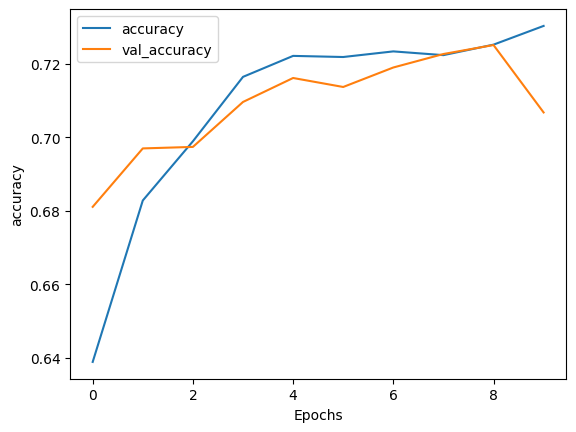

In [22]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

In [23]:
# Konversi probabilitas menjadi label sentimen
def convert_to_sentiment_label_3(probabilities):
    # Tentukan indeks dengan probabilitas tertinggi
    max_prob_index = np.argmax(probabilities)

    # Definisikan kelas sentimen berdasarkan indeks probabilitas tertinggi
    if max_prob_index == 0:
        return "Netral"
    elif max_prob_index == 1:
        return "Negatif"
    else:
        return "Positif"
    
# Kalimat untuk diuji
sentence = "jokowi adalah presiden yang baik dan bijaksana"

# Lakukan transformasi TF-IDF pada kalimat
sentence_vectorized = vectorizer.transform([sentence]).toarray()

# Lakukan prediksi sentimen menggunakan model yang telah dilatih
prediction = model.predict(sentence_vectorized)    

# Konversi probabilitas menjadi label sentimen
sentiment_label = convert_to_sentiment_label_3(prediction[0])

# Tampilkan hasil prediksi
print(prediction)
print("Sentimen:", sentiment_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
[[0.28904274 0.578035   0.13292223]]
Sentimen: Negatif


In [24]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mencetak classification report
print(classification_report(y_test, y_pred_classes))

77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       242
           1       0.53      0.81      0.64       782
           2       0.87      0.76      0.81      1428

    accuracy                           0.71      2452
   macro avg       0.80      0.54      0.51      2452
weighted avg       0.78      0.71      0.69      2452



In [72]:
## save model
model.save('tf-idf-cnn-3-classes.h5')